In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from functools import partial

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

2023-02-13 18:11:30.707651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 18:11:31.376796: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-13 18:11:32.594257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/leo/anaconda3/lib/
2023-02-13 18:11:32.594385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cann

In [2]:
sys.path.append(os.path.abspath(os.path.join('../../..')))
from bayesflow.simulation import Prior, Simulator, GenerativeModel
from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.trainers import Trainer
import bayesflow.diagnostics as diag

/home/leo/Workspace/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Introduction

In this tutorial, we will demonstrate the application of BayesFlow to PDEs. This means our observations have both a time and space dependency. Specifically, we will look at heat diffusion on two rings:
<br><br>
$$
\partial_t u(x, t) - D_u \Delta u(x, t) = 0 \\
\partial_t v(x, t) - D_v \Delta v(x, t) = 0
$$
<br><br>
Here, $u(x, t)$ and $v(x, t)$ describe the heat distribution on the rings over time, $x$ is the position on the ring and $t$ the time. The diffusion constants $D_u, D_v$ are constant over time for heat diffusion. 


For simplicity, we assume no interaction between the two rings in this tutorial. For modelling the interaction between the rings, one can replace the zeros on the right handside of both PDEs with interaction terms. The heat diffusion on a hollow cylinder could be described by stacking $n$ such rings with appropriate interaction terms. However for this tutorial, we only model the diffusion along one spacial dimension in time on two separate non-interacting rings.

Additionally to the PDEs, we need to define initial conditions at $t=0$ for our PDE system:
<br><br>
$$
u_0(x) = \gamma_u \cdot sin(\alpha_u x) \\
v_0(x) = \gamma_v \cdot cos(\alpha_v x)
$$
<br><br>
The goal is to estimate the diffusion constants $D_u, D_v$ and the intial condition constants $\alpha_u, \alpha_v, \gamma_u, \gamma_v$ given the heat distributions $u(x, t)$ and $v(x, t)$ over time. 


# Numeric Solver

We solve the PDE system numerically by discretization in space dimension. For each discrete point $i$ on the ring, we can approximate the diffusion as heat flowing to its neighbor points $i-1$ and $i+1$:
<br><br>
$$
\partial_t u_i(t) - D_u [u_{i-1}(t) - 2 u_i(t) + u_{i+1}(t)] = 0 \\
\partial_t v_i(t) - D_v [v_{i-1}(t) - 2 v_i(t) + v_{i+1}(t)] = 0
$$
<br><br>
This allows us to solve the PDE system similarly to an ODE system by discretization in time using the $\textit{odeint}$ function from $\textit{scipy}$. For data generation, we define a simulator function wrapped with the `Simulator` wrapper:

In [3]:
t = np.linspace(0, 5, num=20) # time discretization
x = np.linspace(0, 10, 10) # space discretization

def PDE_solver(params, t, x):
    """PDE Numeric Solver"""
    nr = len(x)
    U0 = params[2] * np.sin(params[3] * x)
    V0 = params[4] * np.cos(params[5] * x)
    X0 = np.concatenate((U0, V0))
    
    def diffusion_pde(X, t):
        diff_matrix = (
                np.diag(np.full(nr, -2))
                + np.diag(np.ones(nr - 1), 1)
                + np.diag(np.ones(nr - 1), -1)
                + np.diag(np.ones(1), nr - 1)
                + np.diag(np.ones(1), 1 - nr)
        )

        zero_matrix = np.zeros((nr, nr))
        
        Du_matrix = params[0] * diff_matrix
        Dv_matrix = params[1] * diff_matrix
        
        Du_matrix_zero = np.concatenate((Du_matrix, zero_matrix), axis=1)
        Dv_matrix_zero = np.concatenate((zero_matrix, Dv_matrix), axis=1)
        
        D_matrix = np.concatenate((Du_matrix_zero, Dv_matrix_zero), axis=0)
        
        return D_matrix @ X
    
    return odeint(diffusion_pde, X0, t)

simulator = Simulator(simulator_fun=partial(PDE_solver, t=t, x=x))

The $\textit{simulator}$ needs the parameters $D_u, D_v, \alpha_u, \alpha_v, \gamma_u, \gamma_v$ as input to generate the heat distributions $u(x, t), v(x, t)$. Therefore, we need to define a prior sampling function, that gives us random combinations of our parameters $D_u, D_v, \alpha_u, \alpha_v, \gamma_u, \gamma_v$. The diffusion constants $D_u, D_v$ are only sampled in the positive range, because a negative diffusion constant does not make sense for the real world interpretation of heat diffusion. We choose a uniform prior distribution and warp the prior function into the `Prior` wrapper. Additionally, we estimate the prior means and standard deviations for standardization later.

In [4]:
def model_prior():
    """Generates random draws from uniform pior"""
    sample = np.random.uniform(low=[0, 0, -1, -1, -1, -1], high=[1, 1, 1, 1, 1, 1], size=6)
    return sample

prior = Prior(prior_fun=model_prior, param_names=[r'$D_u$', r'$D_v$', r'$\gamma_u$', r'$\alpha_u$', r'$\gamma_v$', r'$\alpha_v$'])
prior_means, prior_stds = prior.estimate_means_and_stds()

Finally, we will wrap the prior and simulator into a `GenerativeModel` which will connect the prior with the simulator:

In [5]:
model = GenerativeModel(prior, simulator, name='PDE_generator')  

INFO:root:Performing 2 pilot runs with the PDE_generator model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 20, 20)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


As a sanity check, we can sample 1000 prior combinations and visualize the joint priors in bivariate plots:

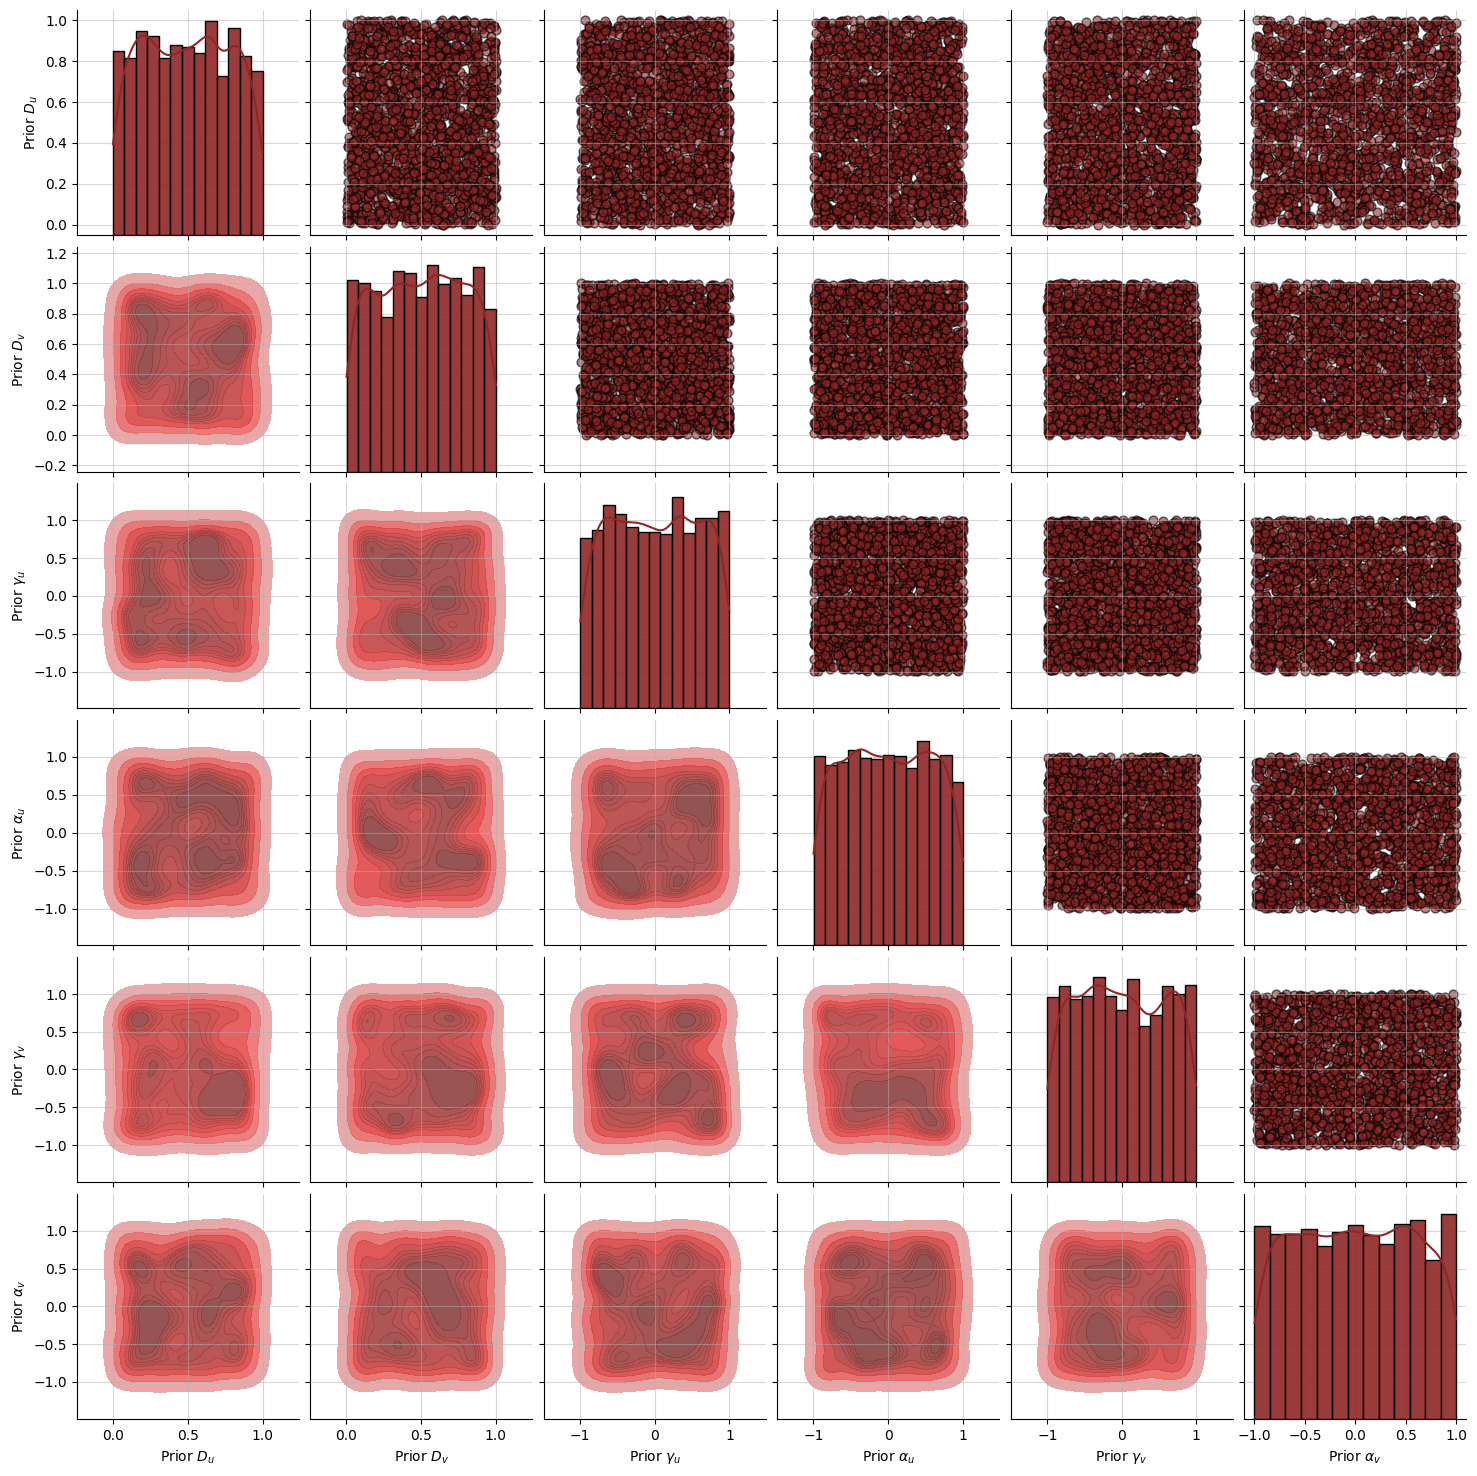

In [6]:
fig = prior.plot_prior2d()

Additionally, we can visualize the the heat distributions $u(x, t)$ and $v(x, t)$:

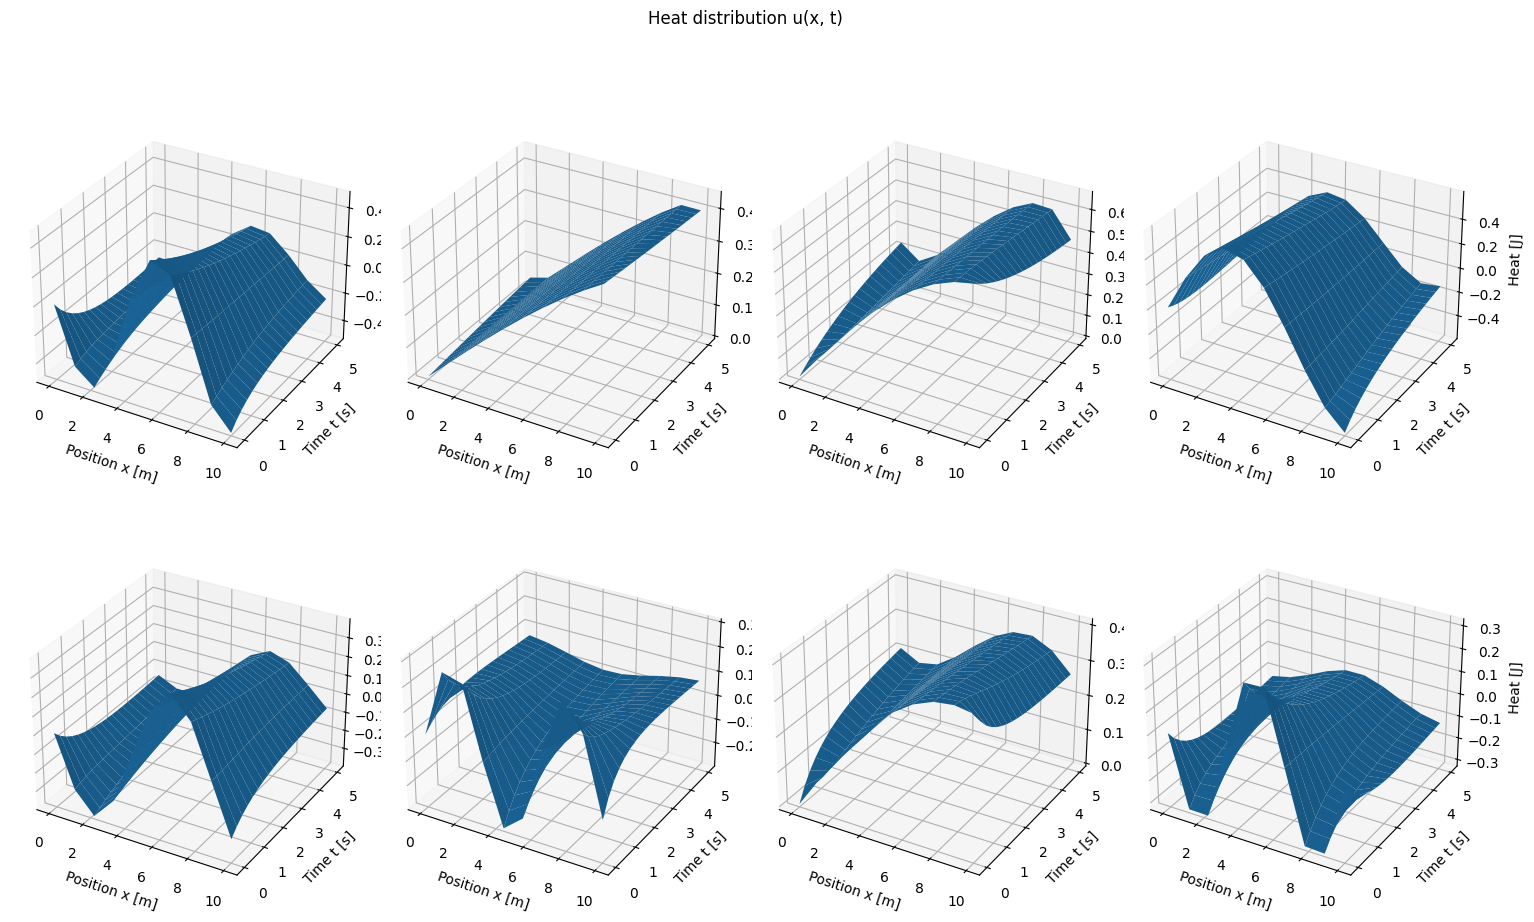

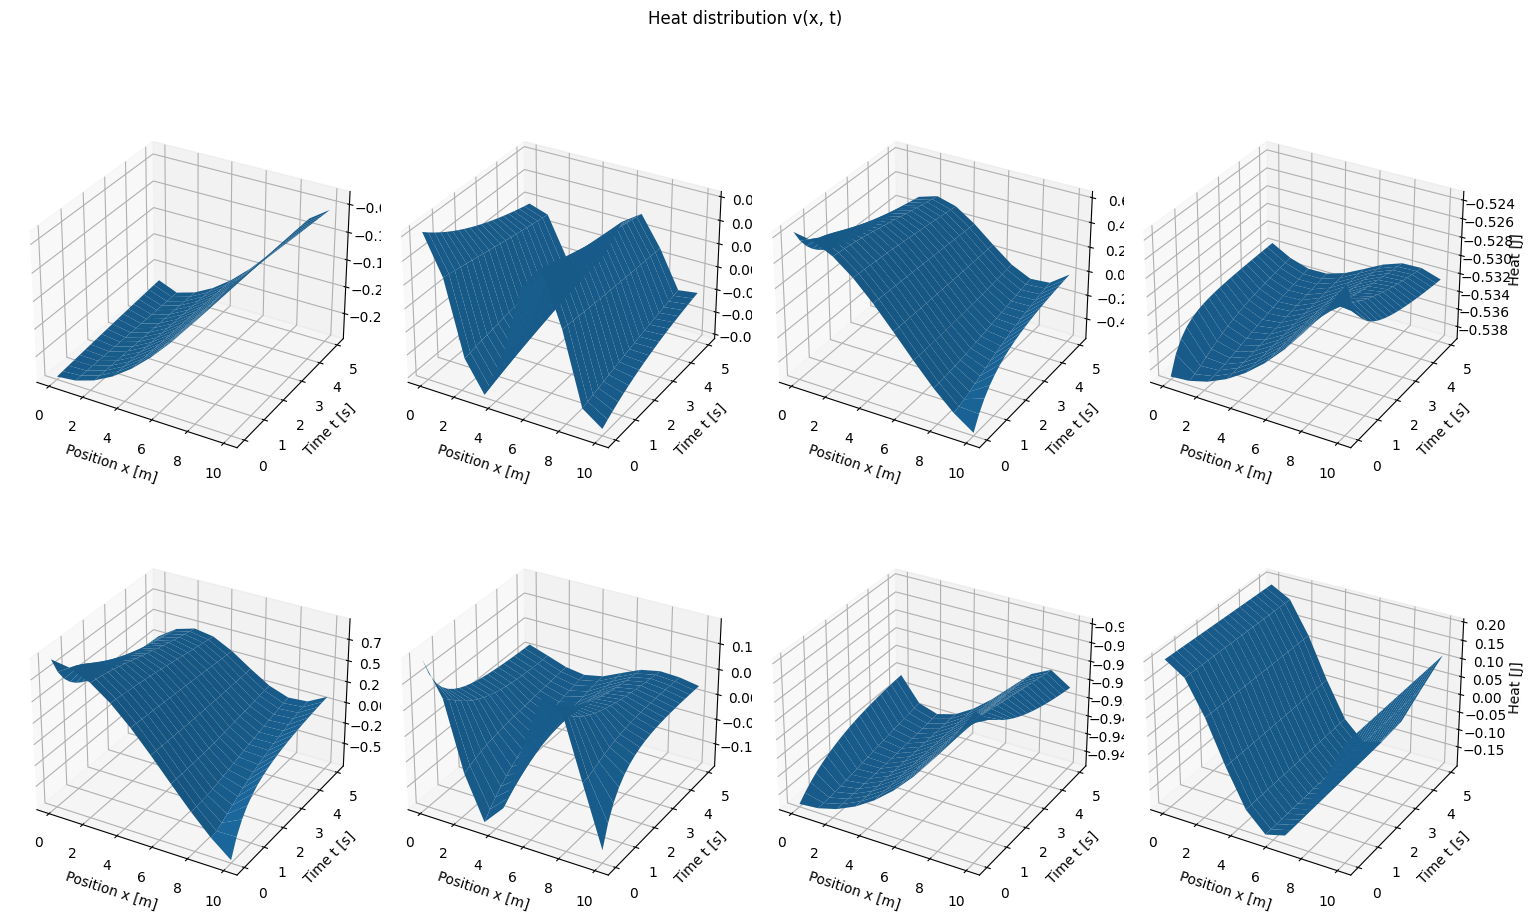

In [7]:
sim_data = model(8)['sim_data']

fig = plt.figure(figsize=(15, 10))
for i, data in enumerate(sim_data):
    ax = fig.add_subplot(int("24{}".format(i+1)), projection="3d")
    X, Y = np.meshgrid(x, t)
    mappable = plt.cm.ScalarMappable()
    mappable.set_array(sim_data[i, :, :len(x)])
    ax.plot_surface(X, Y, sim_data[i, :, :len(x)])
    ax.set_xlabel("Position x [m]")
    ax.set_ylabel("Time t [s]")
    ax.set_zlabel("Heat [J]")
fig.suptitle("Heat distribution u(x, t)")
plt.tight_layout()
plt.show()
plt.close()

fig = plt.figure(figsize=(15, 10))
for i, data in enumerate(sim_data):
    ax = fig.add_subplot(int("24{}".format(i+1)), projection="3d")
    X, Y = np.meshgrid(x, t)
    mappable = plt.cm.ScalarMappable()
    mappable.set_array(sim_data[i, :, len(x):])
    ax.plot_surface(X, Y, sim_data[i, :, len(x):])
    ax.set_xlabel("Position x [m]")
    ax.set_ylabel("Time t [s]")
    ax.set_zlabel("Heat [J]")
fig.suptitle("Heat distribution v(x, t)")
plt.tight_layout()
plt.show()
plt.close()
    

# BayesFlow Architecture

The BayesFlow architecture consists of a summary network and an invertible neural network. The summary network learns summary statistics for each input, such that the summary network output will have dimensions `(batch_size, summary_dim)`. The invertible inference neural network is conditioned on the summary statistics of the summary network.

## Summary Network

For this tutorial, we will use a small LSTM summary network with dense layers:

In [8]:
class LSTM(tf.keras.Model):
    def __init__(self, hidden_size=512, summary_dim=128):
        super(LSTM, self).__init__()
        
        self.LSTM = tf.keras.Sequential([
            tf.keras.layers.LSTM(hidden_size),
            tf.keras.layers.Dense(hidden_size, activation="relu"),
            tf.keras.layers.Dense(summary_dim, activation="sigmoid")
        ])
        
    def call(self, x, **kwargs):
        out = self.LSTM(x)
        return out
    
    
summary_net = LSTM()

2023-02-13 18:11:56.654461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 18:11:56.720264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 18:11:56.721519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 18:11:56.723969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Inference Network

For the inference network, we will use a 10-layer conditional invertible neural network (cINN):

In [9]:
COUPLING_NET_SETTINGS = {
        't_args': {
            'dense_args': dict(units=128, kernel_initializer='glorot_uniform', activation='elu'),
            'num_dense': 2,
            'spec_norm': False,
            'mc_dropout': False,
            'dropout': False,
            'dropout_prob': 0.1
        },
        's_args': {
            'dense_args': dict(units=128, kernel_initializer='glorot_uniform', activation='elu'),
            'num_dense': 2,
            'spec_norm': False,
            'mc_dropout': False,
            'dropout': False,
            'dropout_prob': 0.1
        },
}

inference_net = InvertibleNetwork(num_params=6, num_coupling_layers=10, coupling_net_settings=COUPLING_NET_SETTINGS)

Finally, we connect the summary network and inference network into an `AmortizedPosterior` instance:

In [10]:
amortizer = AmortizedPosterior(inference_net, summary_net, name="PDE_amortizer")

# Preprocessing

Before we feed the simulation data to our BayesFlow amortizer, we want to perform some preprocessing such as normalization, logscale conversion for stability, and removing nan/infinite samples.

In [11]:
data = model(batch_size=1000)
sim_mean = np.mean(data['sim_data'])
sim_std = np.std(data['sim_data'])

def configure_input(forward_dict):
    """Configures dictionary of prior draws and simulated data into BayesFlow format."""
    
    out_dict = {}
    
    # standardization sim_data
    sim_data = forward_dict['sim_data'].astype(np.float32)
    norm_data = (sim_data - sim_mean) / sim_std
    
    # standardization priors
    params = forward_dict['prior_draws'].astype(np.float32)
    norm_params = (params - prior_means) / prior_stds
    
    # remove nan, inf and -inf
    keep_idx = np.all(np.isfinite(norm_data), axis=(1, 2))
    if not np.all(keep_idx):
        print('Invalid value encountered...removing from batch')
        
    # add to dict
    out_dict['summary_conditions'] = norm_data[keep_idx]
    out_dict['parameters'] = norm_params[keep_idx]
    
    return out_dict

# Training

To train our BayesFlow amortizer, we first have to define a `Trainer` instance, which will take care of simulation-based training. By default, a cosine decay learning rate scheduler is used during training with the default starting learning rate of 0.0005. Once we initialized the Trainer instance and run a consistency check on a test batch, we can print the number of trainable and non-trainable parameters in our BayesFlow model.

In [12]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configure_input
)
amortizer.summary()

INFO:root:Performing a consistency check with provided components...
2023-02-13 18:12:06.257168: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
INFO:root:Done.


Model: "PDE_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 1352040   
 bleNetwork)                                                     
                                                                 
 lstm (LSTM)                 multiple                  1419904   
                                                                 
Total params: 2,771,944
Trainable params: 2,771,824
Non-trainable params: 120
_________________________________________________________________


Now, we can train our BayesFlow architecture using round-based learning. This approach saves simulation time by reusing already generated datasets from previous rounds for training. The disadvantage of this training method is, that we have an increased chance of overfitting compared to online training.  
<br>
Note: For the purpose of this tutorial, we tried to restrict notebook runtime to around 20min (using Ryzen 7 and Nvidia GTX 1080). Better results with lower uncertainties can be achieved by increasing the number of training iterations and the representation capacities of both summary and inference network. 

In [13]:
losses = trainer.train_rounds(rounds=5, sim_per_round=3200, epochs=20, batch_size=32)

INFO:root:Simulating initial 3200 data sets for training...


Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/100 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Simulating new 3200 data sets and appending to previous...
INFO:root:New total number of simulated data sets for training: 6400


Training epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/200 [00:00<?, ?it/s]

INFO:root:Simulating new 3200 data sets and appending to previous...
INFO:root:New total number of simulated data sets for training: 9600


Training epoch 1:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/300 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/300 [00:00<?, ?it/s]

INFO:root:Simulating new 3200 data sets and appending to previous...
INFO:root:New total number of simulated data sets for training: 12800


Training epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/400 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/400 [00:00<?, ?it/s]

INFO:root:Simulating new 3200 data sets and appending to previous...
INFO:root:New total number of simulated data sets for training: 16000


Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/500 [00:00<?, ?it/s]

We can visualize the training loss to inspect, if the training has converge.

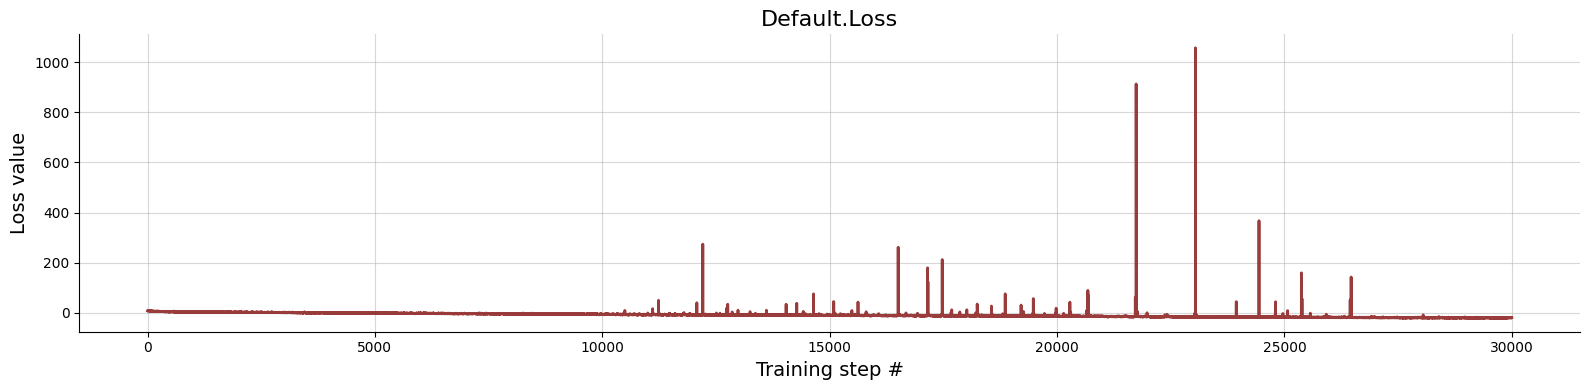

In [14]:
fig = diag.plot_losses(losses)

# Symmetry of Initial Conditions

Note that multiple combination of our parameters $\alpha_u, \alpha_v, \gamma_u$ can lead to the same initial conditions for our PDE system:
<br><br>
$$
u_0(x) = \gamma_u \cdot sin(\alpha_u x) \\
v_0(x) = \gamma_v \cdot cos(\alpha_v x)
$$
<br><br>
The reason is the symmetry of the sine and cosine functions:
<br><br>
$$
cos(-\theta) = cos(\theta) \\
sin(-\theta) = -sin(\theta)
$$
<br><br>
Therefore, if $\alpha_v$ is a possible hidden parameter than $-\alpha_v$ is as well. Analogously, if $\alpha_u$ and $\gamma_u$ are possible hidden parameters than $-\alpha_u$ and $-\gamma_u$ are as well. The fact, that multiple hidden parameter values are possible solutions leads to multimodal posteriors, which BayesFlow can correctly predict: 

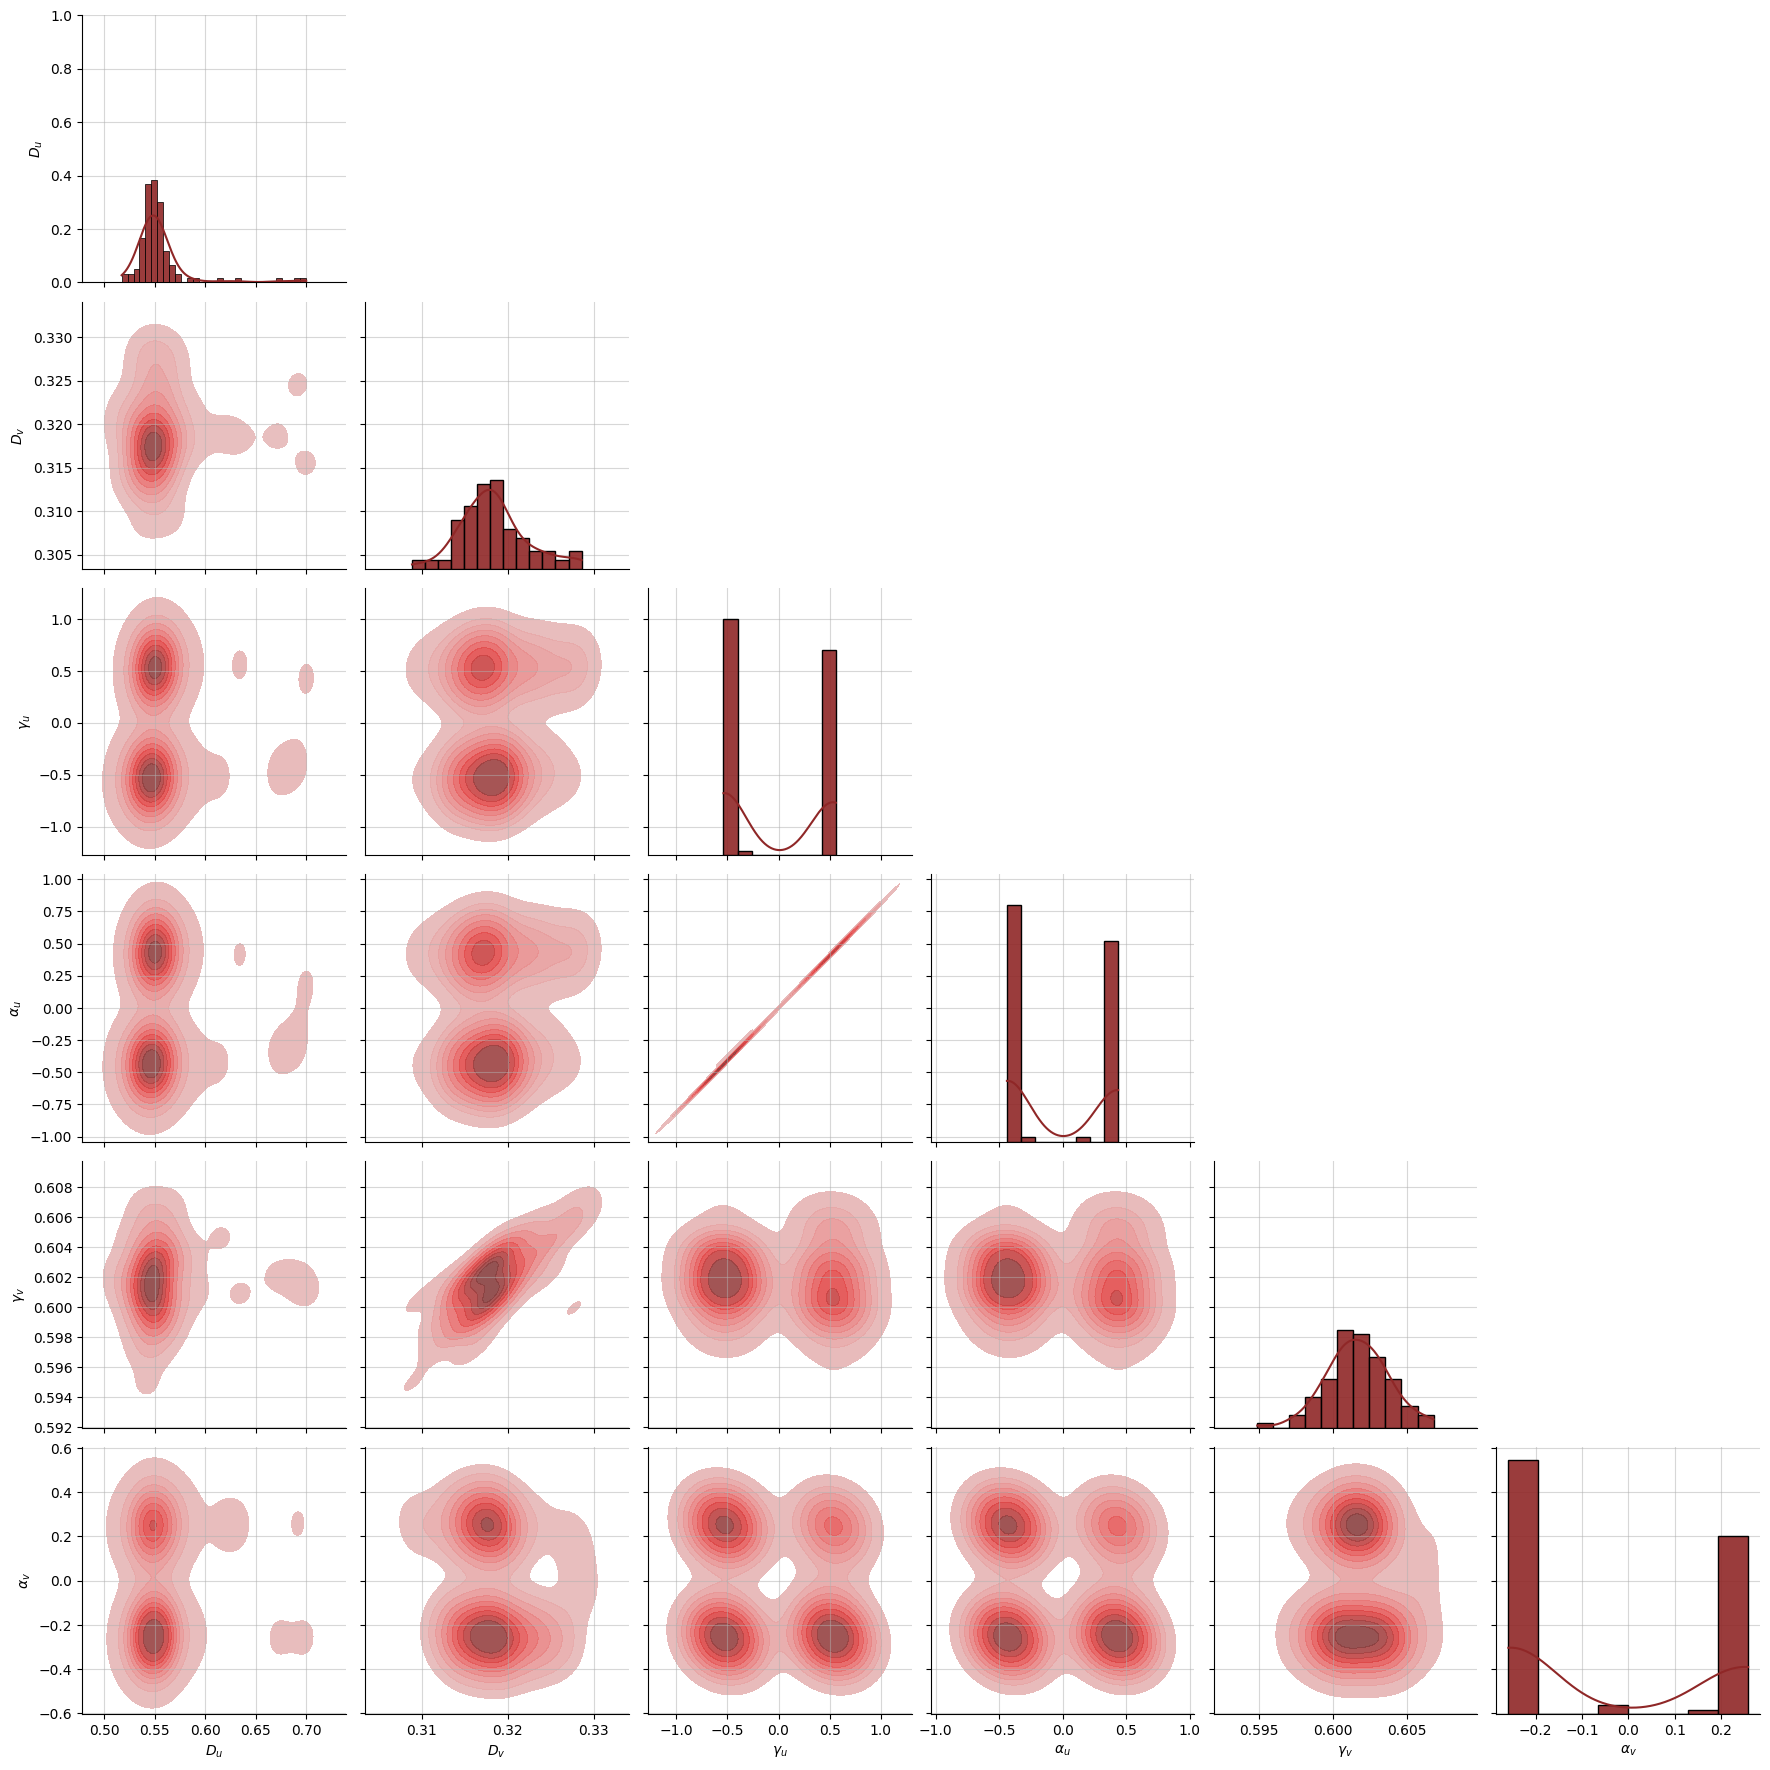

In [16]:
valid_sim_data_raw = model(batch_size=300)
valid_sim_data = trainer.configurator(valid_sim_data_raw)
posterior_samples = amortizer.sample(valid_sim_data, n_samples=100)
posterior_samples_unnorm = prior_means + posterior_samples * prior_stds
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], param_names=prior.param_names)

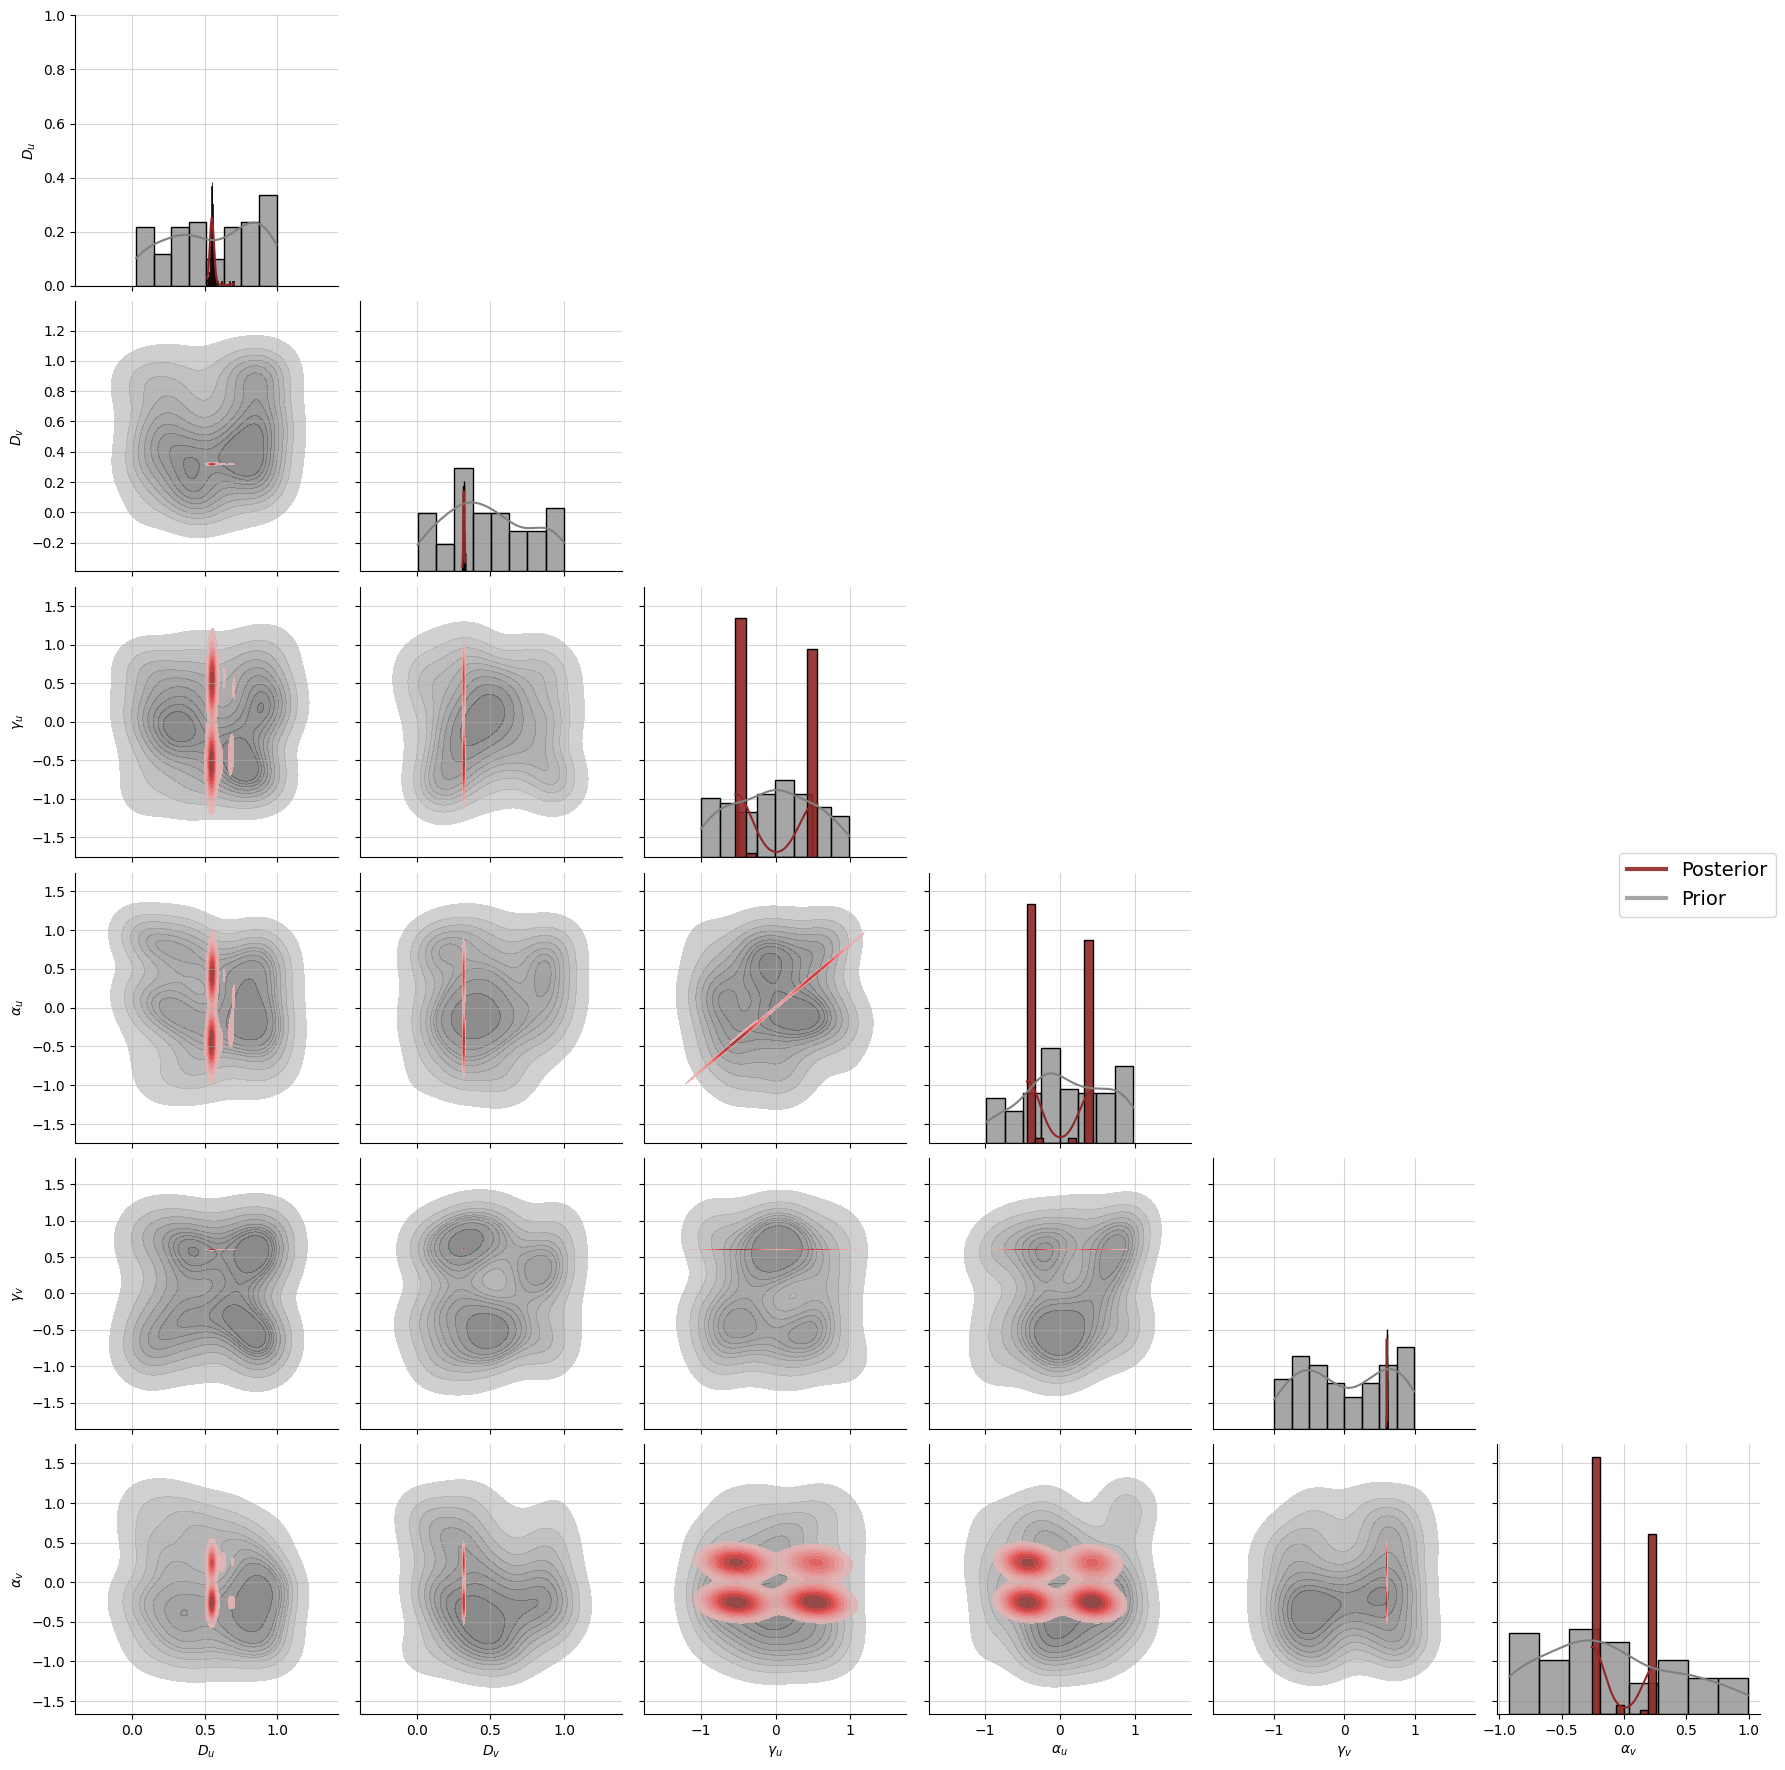

In [17]:
fig = diag.plot_posterior_2d(posterior_samples_unnorm[0], prior=prior)

During inference, BayesFlow will provide us with a posterior distribution for every hidden parameter and every possible solution. To get a point estimate from BayesFlow, we will simply take the median value of the posterior. For validation, we can plot the posterior median value against the ground truth and compute the R Squared for our model. In the ideal case, all predicted values should lie on the diagonal line (posterior standard deviations are also plotted for an uncertainty measure). However, as discussed above, we have ambiguous signs for the parameters $\alpha_u, \alpha_v, \gamma_u$. For these 3 parameters the R Squared score is not very meaningful, since the sign can not be inferred from the observation. As seen below, BayesFlow can correctly predict the posterior for these 3 parameters and we can even extract the correct absolute values, where the sign is only wrong half of the time. This is an expected behaviors, because both signs for those 3 parameters are equally likely under the given observation.  

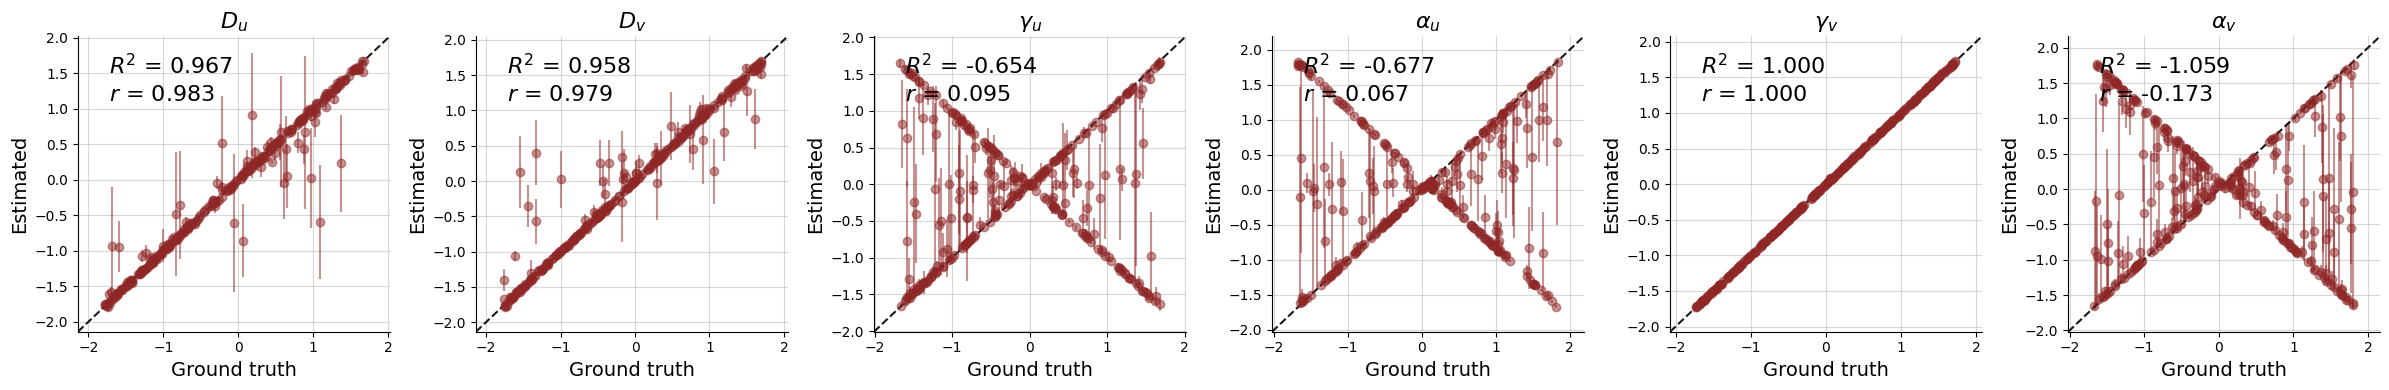

In [18]:
fig = diag.plot_recovery(posterior_samples, valid_sim_data['parameters'], param_names=prior.param_names)

# Latent space structure of multimodel joint distributions

Our inference network is a conditional invertible neural network (cINN), that learns an invertible and differentiable function between the latent space and the hidden parameter space. Note that continuity is a necessary condition for differentiability. Therefore, every function learned by the cINN will be countinous. In other words, if our joint posterior is multimodal, then the transformed joint posterior into the latent space will also be multimodal due to the continuity of the learned invertible function by the cINN. Since our training objective assumes a monomodal Gaussian distribution as our target distribution in the latent space, BayesFlow will try to move the multiple modes in the transformed posterior close to each other such that they approximate a Gaussian distribution. For longer training, the multiple modes in the latent space might not be visible by eye anymore, but should still exists in theory.

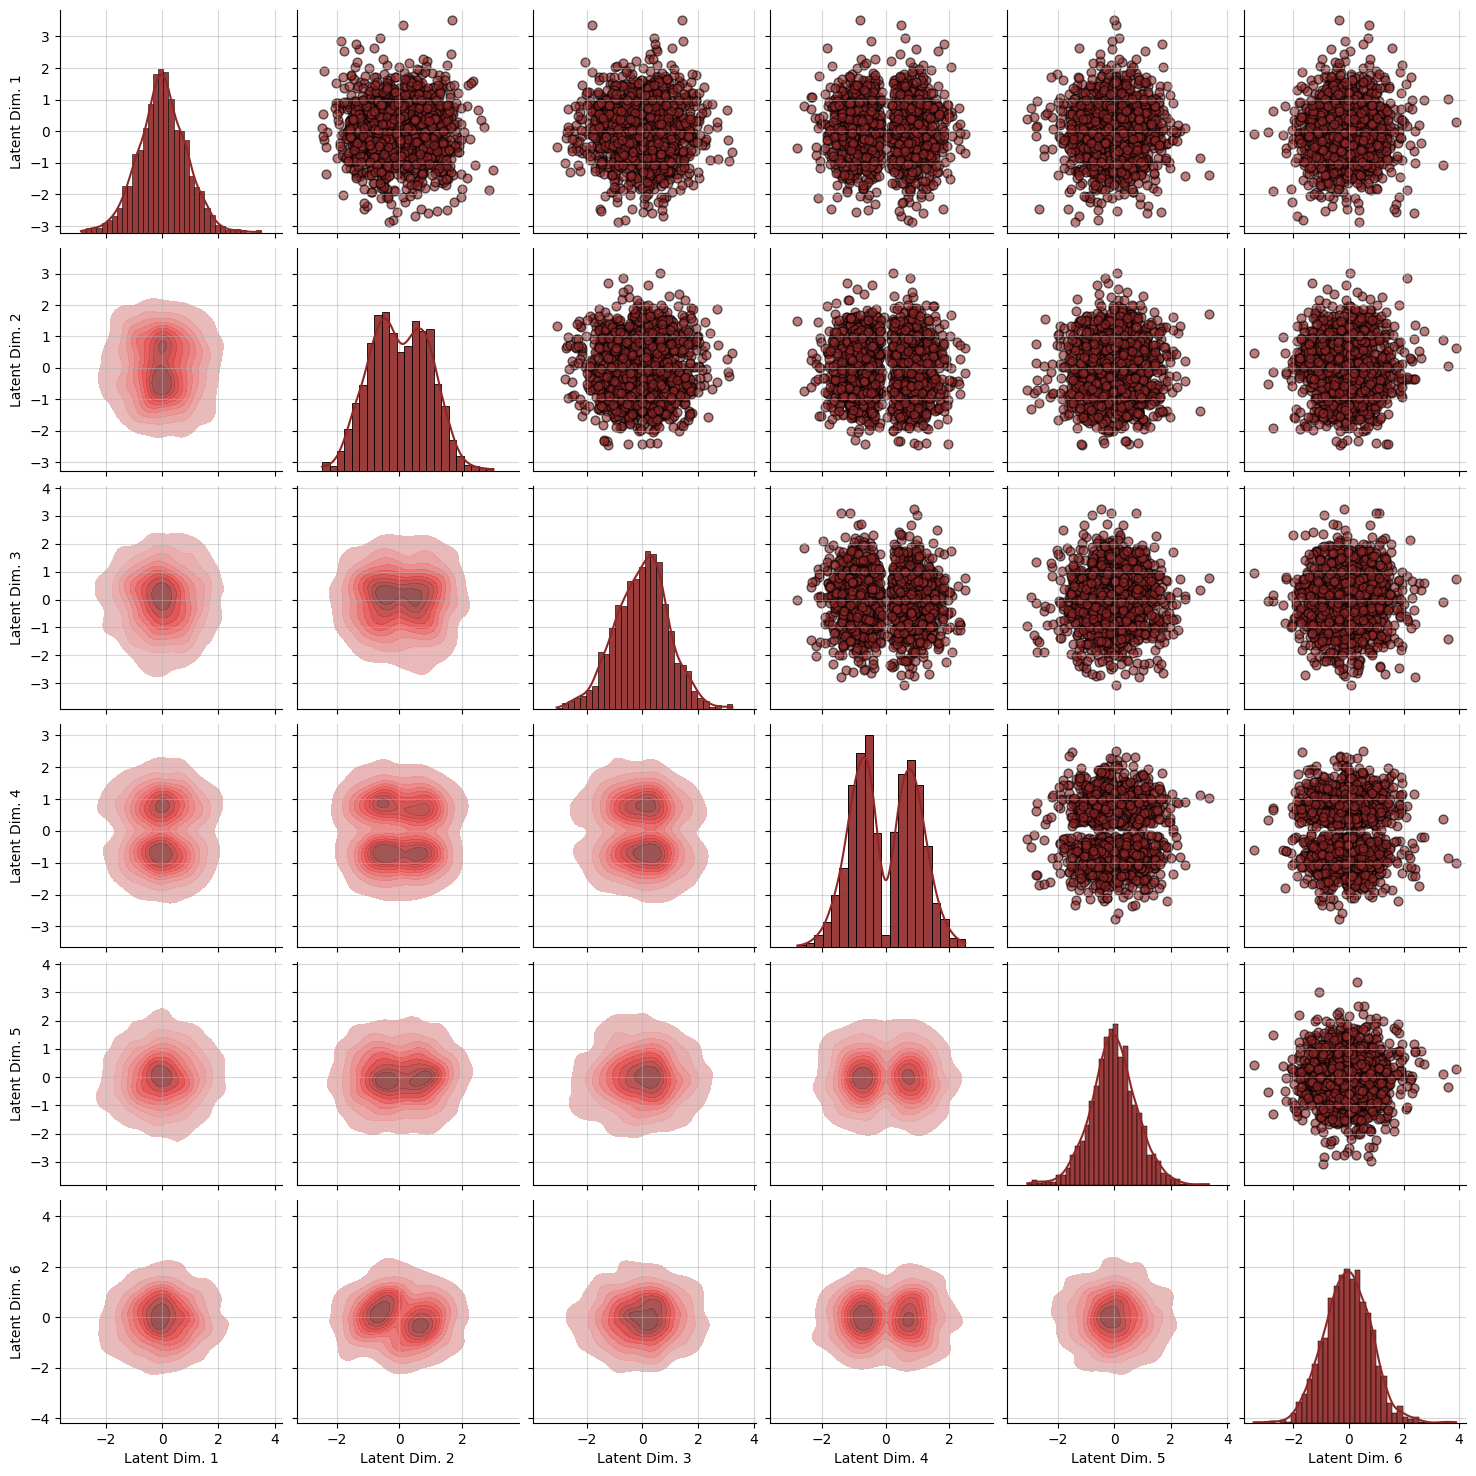

In [19]:
fig = trainer.diagnose_latent2d()

# Calibration

Next we can perform simulation-based calibration (SBC) through histograms as proposed by [Talts et al. (2020)](https://arxiv.org/pdf/1804.06788.pdf) and through empirical cumulative distribution functions (ECDF) as proposed by [Teemu Säilynoja et al. (2021)](https://arxiv.org/pdf/2103.10522.pdf). We observe that BayesFlow is underconfident in its predicted posterior, meaning it predicts a broader posterior with higher standard deviations than the true posterior. The reasons may be the ambiguous signs for the parameters $\alpha_u, \alpha_v, \gamma_u$ and the continuity constraint of the learned function by the cINN.

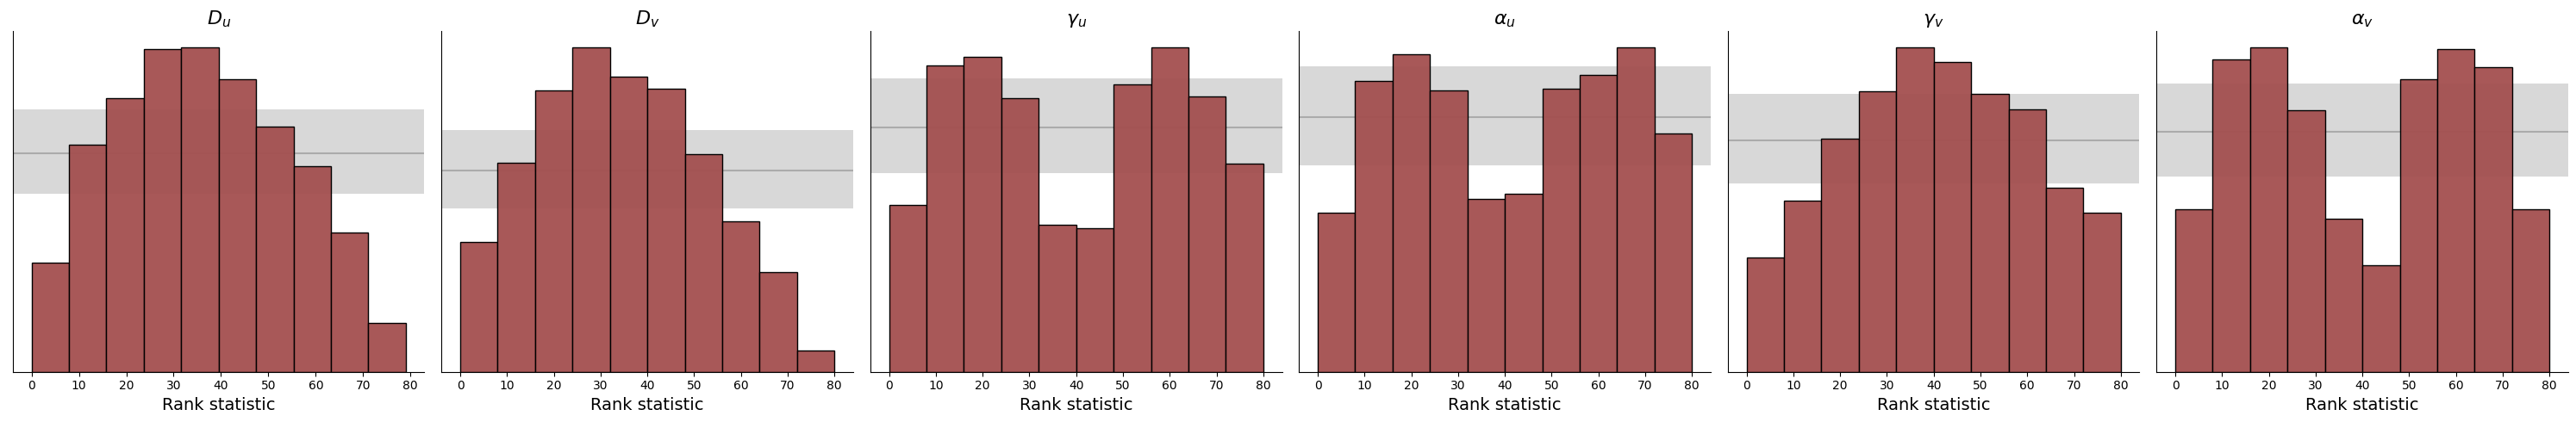

In [20]:
fig = trainer.diagnose_sbc_histograms()

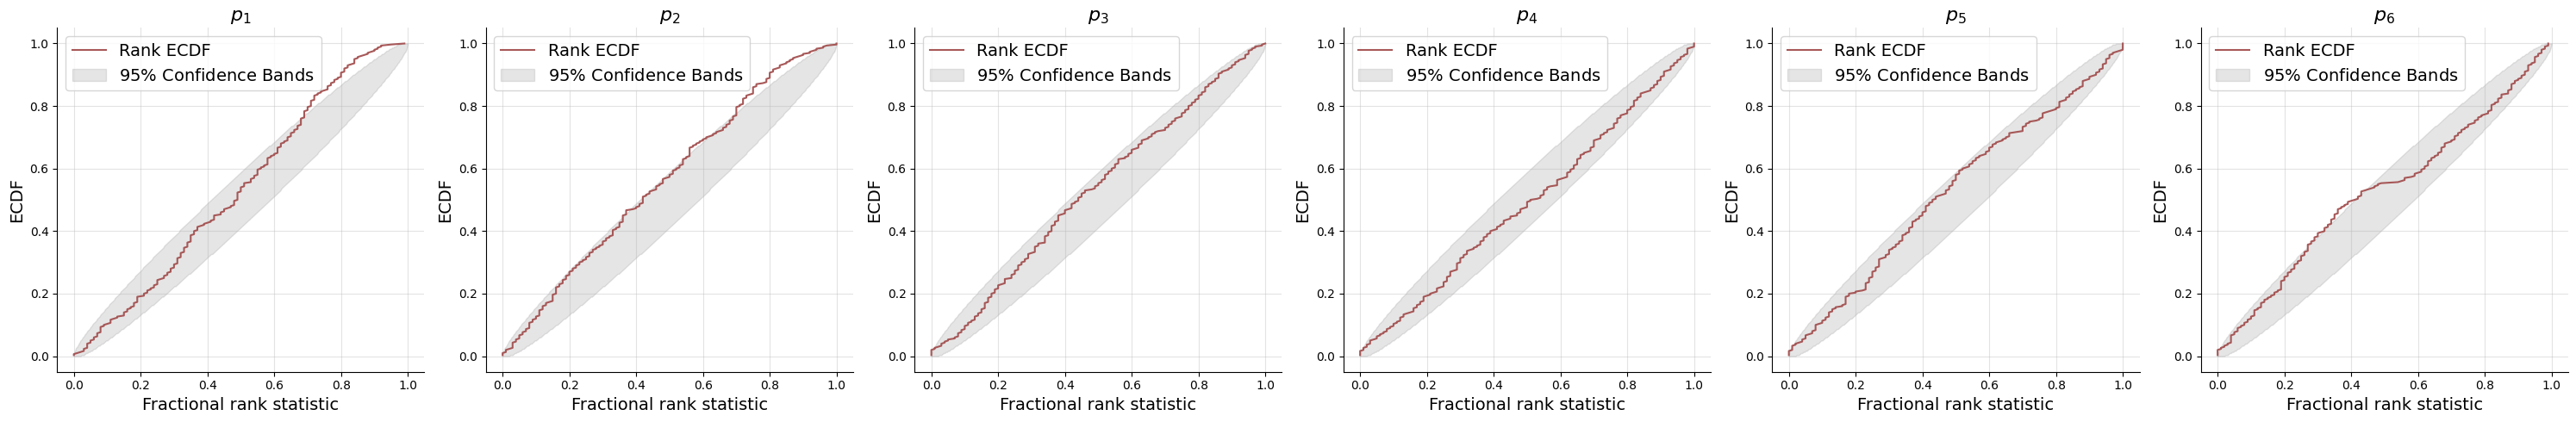

In [21]:
fig = diag.plot_sbc_ecdf(posterior_samples, valid_sim_data['parameters'])

# Resimulation

The last check we want to perform is re-simulation (also known as posterior predictive checks). Given a set of heat distributions $u(x, t)$ and $v(x, t)$, we predict the posterior of diffusion constants $D_u, D_v$ and the intial condition constants $\alpha_u, \alpha_v, \gamma_u, \gamma_v$. All parameter posterior samples will then be passed to the simulator to re-simulate $\hat{u}_i(x, t)$ and $\hat{v}_i(x, t)$. Finally, we compute the median and quantile between all $\hat{u}_i(x, t)$ and $\hat{v}_i(x, t)$ and compare to the ground truth solutions $u(x, t)$ and $v(x, t)$. Since our simulation data $u(x, t)$ and $v(x, t)$ is dependent on two parameters, we will generate a separate plot for each position $x$ as a time series in $t$:

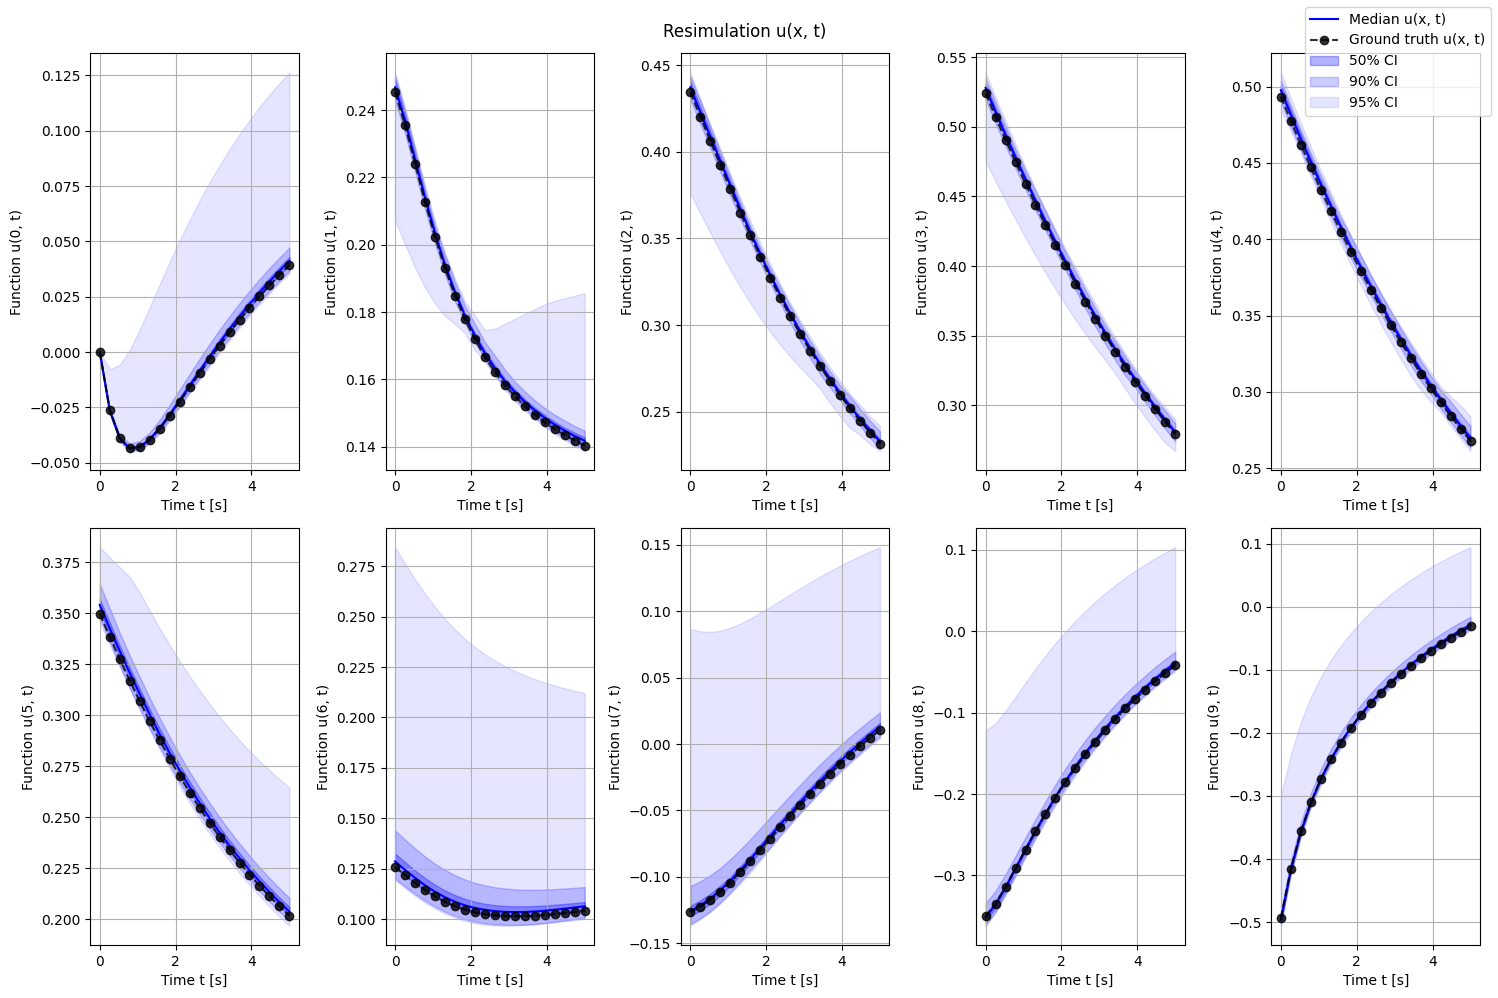

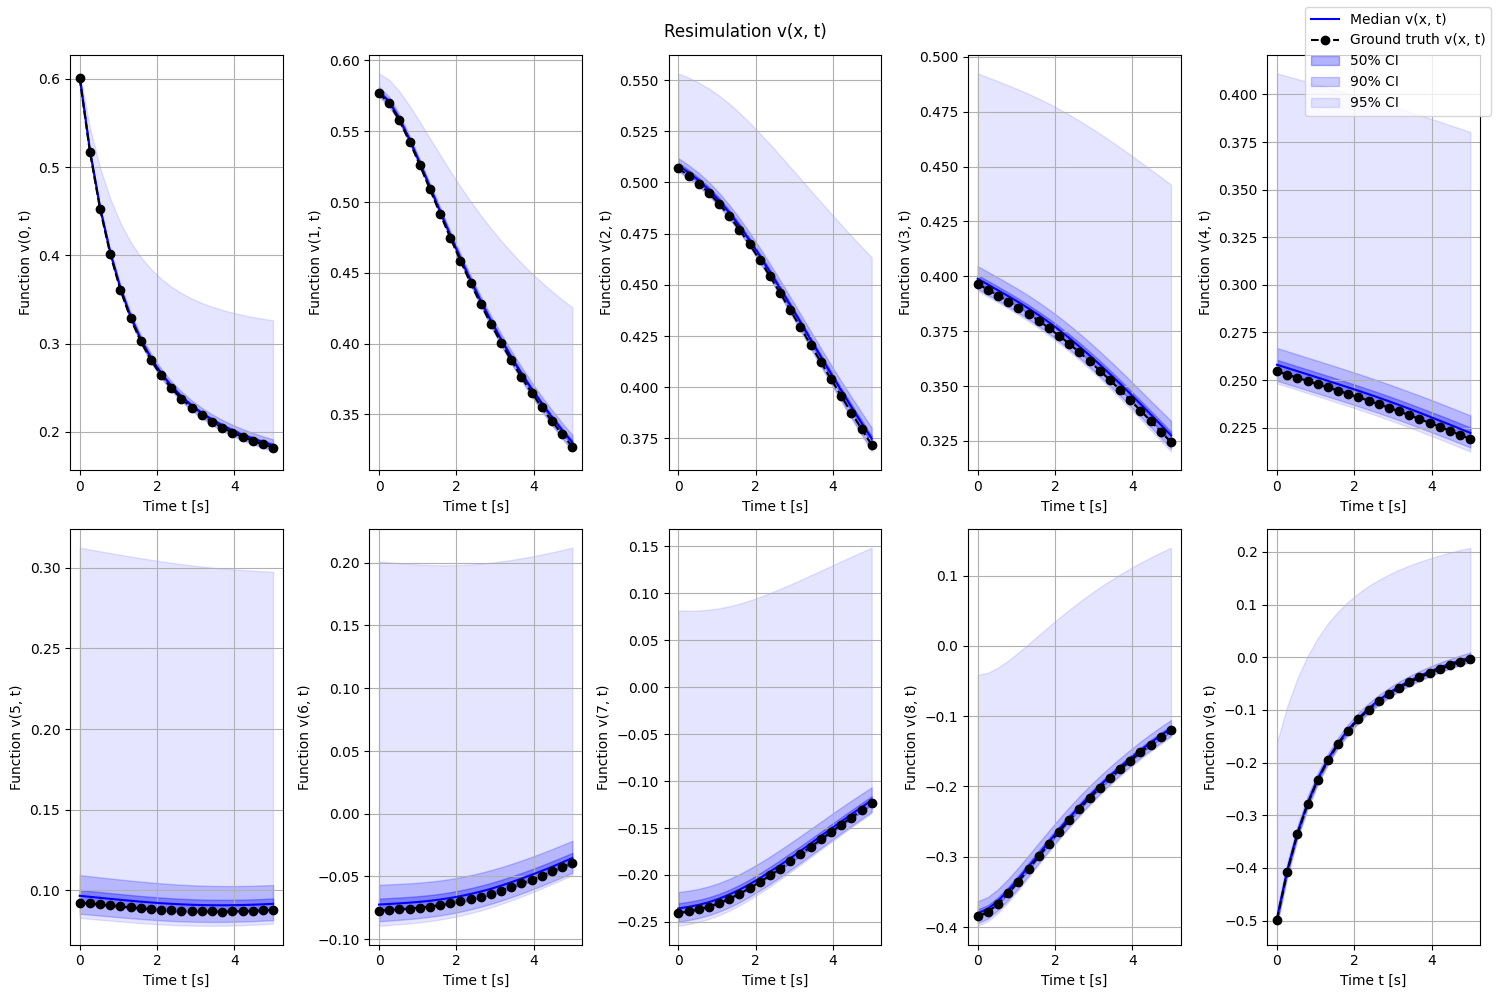

In [22]:
resim_u = np.empty((posterior_samples_unnorm[0].shape[0], len(t), len(x)), dtype=np.float32)
resim_v = np.empty((posterior_samples_unnorm[0].shape[0], len(t), len(x)), dtype=np.float32)

for i in range(posterior_samples_unnorm[0].shape[0]):
    re_sim = PDE_solver(posterior_samples_unnorm[0, i], t, x)
    resim_u[i, :, :] = re_sim[:, :len(x)]
    resim_v[i, :, :] = re_sim[:, len(x):]
    
fig = plt.figure(figsize=(15, 10))
for k in range(len(x)):
    ax = fig.add_subplot(2, 5, k+1)
    ax.plot(t, np.median(resim_u[:, :, k], axis=0), label='Median u(x, t)', color='b')
    ax.plot(t, valid_sim_data_raw['sim_data'][0, :, k], marker='o', label='Ground truth u(x, t)', color='k', linestyle='--', alpha=0.8)
    
    u_qt_50 = np.quantile(resim_u[:, :, k], q=[0.25, 0.75], axis=0)
    u_qt_90 = np.quantile(resim_u[:, :, k], q=[0.05, 0.95], axis=0)
    u_qt_95 = np.quantile(resim_u[:, :, k], q=[0.025, 0.975], axis=0)

    ax.fill_between(t, u_qt_50[0], u_qt_50[1], color='b', alpha=0.3, label="50% CI")
    ax.fill_between(t, u_qt_90[0], u_qt_90[1], color='b', alpha=0.2, label="90% CI")
    ax.fill_between(t, u_qt_95[0], u_qt_95[1], color='b', alpha=0.1, label="95% CI")

    ax.grid(True)
    ax.set_xlabel("Time t [s]")
    ax.set_ylabel("Function u({}, t)".format(k))
    handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)
fig.suptitle("Resimulation u(x, t)")
plt.tight_layout()
plt.show()
plt.close()

fig = plt.figure(figsize=(15, 10))
for k in range(len(x)):
    ax = fig.add_subplot(2, 5, k+1)
    ax.plot(t, np.median(resim_v[:, :, k], axis=0), label='Median v(x, t)', color='b')
    ax.plot(t, valid_sim_data_raw['sim_data'][0, :, k+len(x)], marker='o', label='Ground truth v(x, t)', color='k', linestyle='--')
    
    v_qt_50 = np.quantile(resim_v[:, :, k], q=[0.25, 0.75], axis=0)
    v_qt_90 = np.quantile(resim_v[:, :, k], q=[0.05, 0.95], axis=0)
    v_qt_95 = np.quantile(resim_v[:, :, k], q=[0.025, 0.975], axis=0)
    
    ax.fill_between(t, v_qt_50[0], v_qt_50[1], color='b', alpha=0.3, label="50% CI")
    ax.fill_between(t, v_qt_90[0], v_qt_90[1], color='b', alpha=0.2, label="90% CI")
    ax.fill_between(t, v_qt_95[0], v_qt_95[1], color='b', alpha=0.1, label="95% CI")
    
    ax.grid(True)
    ax.set_xlabel("Time t [s]")
    ax.set_ylabel("Function v({}, t)".format(k))
    handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)
fig.suptitle("Resimulation v(x, t)")
plt.tight_layout()
plt.show()
plt.close()   
